In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV

In [3]:
ttype_qual_labels = pd.read_csv("./NotebookInputs/inh_ivscc_shiny_ttype_and_quality.csv",index_col=0)
metatdata_csv = pd.read_csv("./NotebookInputs/20200711_patchseq_metadata_mouse.csv")

no_metadata = [s for s in ttype_qual_labels.index if s not in metatdata_csv.cell_specimen_id.values]
print("The following cells are in shiny but not the manuscript's metadata file:")
print(no_metadata)

merged_labels = ttype_qual_labels.merge(metatdata_csv,left_on='spec_id_label',right_on='cell_specimen_id')
print(merged_labels.shape)

merged_labels_core_i3 = merged_labels[merged_labels['Tree_call_label']!='PoorQ']
#if this fails there is a disagreement between metadata csv ttype and shiny ttype
assert merged_labels_core_i3[merged_labels_core_i3['T-type Label'] != merged_labels_core_i3['Tree_first_cl_label']].empty
print("{} Poor Q Cells dropped".format(len(merged_labels[merged_labels['Tree_call_label']=='PoorQ'])))

The following cells are in shiny but not the manuscript's metadata file:
[761816186, 966835644]
(517, 25)
14 Poor Q Cells dropped


In [4]:
merged_labels_core_i3 = merged_labels[merged_labels['Tree_call_label']!='PoorQ']
#if this fails there is a disagreement between metadata csv ttype and shiny ttype
assert merged_labels_core_i3[merged_labels_core_i3['T-type Label'] != merged_labels_core_i3['Tree_first_cl_label']].empty
print("{} Poor Q Cells dropped".format(len(merged_labels[merged_labels['Tree_call_label']=='PoorQ'])))

14 Poor Q Cells dropped


In [5]:
relevant_cols = ['cell_specimen_id','T-type Label',"MET-type Label","Tree_call_label"]
relevant_labels = merged_labels_core_i3[relevant_cols]
relevant_labels["subclass"] = relevant_labels['T-type Label'].str.split(" ").str.get(0)
relevant_labels["subclass"] = relevant_labels["subclass"].replace("Serpinf1","Vip")

/opt/anaconda3/envs/EM_MC_paper_figs_py36_10/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/anaconda3/envs/EM_MC_paper_figs_py36_10/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [6]:
ivscc_features = pd.read_csv("./NotebookInputs/inh_ivscc_RawFeatureWide.csv",index_col=0)
all_feature_columns = ivscc_features.columns.to_list()
flags = ['rad','diam','area']

droppers = [c for c in all_feature_columns if any([i in c for i in flags])]
print("Dropping:")
for  i in droppers:
    print(i)
all_feature_columns = [c for c in all_feature_columns if c not in droppers]


merged_features = relevant_labels.merge(ivscc_features,right_on='specimen_id',left_on='cell_specimen_id')
labels_to_predict = ['T-type Label',"MET-type Label","subclass"]

merged_features[['cell_specimen_id']+labels_to_predict].to_csv("./CellsUsedInIVSCCClassifiers.csv")
merged_features = merged_features.sample(frac=1)

Dropping:
basal_dendrite_mean_diameter
basal_dendrite_total_surface_area
soma_surface_area


In [7]:
merged_features.shape

(503, 51)

In [8]:
all_feature_columns

['axon_bias_x',
 'axon_bias_y',
 'axon_depth_pc_0',
 'axon_depth_pc_1',
 'axon_depth_pc_2',
 'axon_depth_pc_3',
 'axon_depth_pc_4',
 'axon_emd_with_basal_dendrite',
 'axon_exit_distance',
 'axon_exit_theta',
 'axon_extent_x',
 'axon_extent_y',
 'axon_frac_above_basal_dendrite',
 'axon_frac_below_basal_dendrite',
 'axon_frac_intersect_basal_dendrite',
 'axon_max_branch_order',
 'axon_max_euclidean_distance',
 'axon_max_path_distance',
 'axon_mean_contraction',
 'axon_num_branches',
 'axon_soma_percentile_x',
 'axon_soma_percentile_y',
 'axon_total_length',
 'basal_dendrite_bias_x',
 'basal_dendrite_bias_y',
 'basal_dendrite_calculate_number_of_stems',
 'basal_dendrite_extent_x',
 'basal_dendrite_extent_y',
 'basal_dendrite_frac_above_axon',
 'basal_dendrite_frac_below_axon',
 'basal_dendrite_frac_intersect_axon',
 'basal_dendrite_max_branch_order',
 'basal_dendrite_max_euclidean_distance',
 'basal_dendrite_max_path_distance',
 'basal_dendrite_mean_contraction',
 'basal_dendrite_num_bran

In [9]:
label_column = 'MET-type Label'
X_df = merged_features.copy()

label_count_dict = X_df[label_column].value_counts().to_dict()
below_cutoff = [k for k,v in label_count_dict.items() if int(v) < 5]

X_df = X_df[~X_df[label_column].isin(below_cutoff)]
X_df = X_df[~X_df[label_column].isnull()]


# Feature selection 
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_df[all_feature_columns], X_df[label_column])

feature_importances = clf.feature_importances_
feature_importance_series = pd.Series(feature_importances, index=all_feature_columns).sort_values(ascending=False)

selected_features_importance = feature_importance_series.index.tolist()[:-10]  
dropped_features = feature_importance_series.index.tolist()[-10:]
feature_cols = selected_features_importance

X_df = X_df[[c for c in X_df.columns if c not in dropped_features]]

feat_means = X_df[feature_cols].mean()
feat_std = X_df[feature_cols].std()
# feature_cols = feature_columns
X_df[feature_cols] = (X_df[feature_cols]-X_df[feature_cols].mean())/X_df[feature_cols].std()


X = X_df[feature_cols].values
y = X_df[label_column].values
X_train, X_test, y_train, y_test = train_test_split(X_df[['cell_specimen_id']+feature_cols], 
                                                    y,
                                                    stratify=y, 
                                                    test_size=0.2,
                                                    random_state=42,
                                                   shuffle=True)

training_ids = X_train['cell_specimen_id'].values
testing_ids = X_test['cell_specimen_id'].values

X_train = X_train[feature_cols].values
X_test = X_test[feature_cols].values

assert len(np.unique(y_train)) == len(np.unique(y_test))

In [10]:
# pd.DataFrame(selected_features_importance, columns=['features_included_after_feature_selection']).to_csv("FeatureSelectionWithoutRadius.csv")


In [11]:
# select_with_rad = pd.read_csv("FeatureSelectionWithRadius.csv")
# select_without_rad = pd.read_csv("FeatureSelectionWithoutRadius.csv")
# set(select_with_rad['features_included_after_feature_selection'].values) - set(select_without_rad['features_included_after_feature_selection'].values)

In [12]:

# set(select_without_rad['features_included_after_feature_selection'].values) - set(select_with_rad['features_included_after_feature_selection'].values)

In [13]:

#logisitic regression
logreg_penalty = ["l1","l2","elasticnet",None]
logreg_C = [0.001, 0.005, 0.01, 0.0125, 0.015, 0.025, 0.05, 0.1, 0.25, 1, 5,10]
logreg_intercept_scaling = [1,1.5,2,3,]
logreg_class_weight = ['balanced']
logreg_l1_ratio = [0.25,0.5,0.75]

logreg_grid = {
    "penalty":logreg_penalty,
    "C":logreg_C,
    "intercept_scaling":logreg_intercept_scaling,
    "class_weight":logreg_class_weight,
    "l1_ratio":logreg_l1_ratio
}


#SVM
svm_c = [0.00005, 0.0001, 0.0005,0.001, 0.0025, 0.005 , 0.0075, 0.01, 0.015, 0.025, 0.05, 0.1, 0.25, 1, 5,10]
svm_kernel_params = ["linear", "rbf", 'poly','sigmoid'] 
svm_poly_degree = [3,4,5,6]
svm_gamma = ["scale", "auto"]
svm_class_weight = ['balanced']
probability = [True]
svm_grid = {
    "C":svm_c,
    "kernel":svm_kernel_params,
    "degree":svm_poly_degree,
    "gamma":svm_gamma,
    "class_weight":svm_class_weight,
    "probability":probability,
}

#Random Forest
rfc_n_estimators = [5,10,15,25,40,50,75,150,250] 
rfc_max_features = ['sqrt', None]
rfc_max_depth = [2,3,5,10,20,35,50,100,None]
rfc_min_samples_split = [5,10,20,25]
rfc_min_samples_leaf = [5, 10,15,25]
rfc_bootstrap = [True]
rfc_class_weight= ['balanced']

rfc_random_grid = {
    'n_estimators': rfc_n_estimators,
    'max_features': rfc_max_features,
    'max_depth': rfc_max_depth,
    'min_samples_split': rfc_min_samples_split,
    'min_samples_leaf': rfc_min_samples_leaf,
    'bootstrap': rfc_bootstrap,
    'class_weight':rfc_class_weight,
}





meta_config_dict = {
        
    "LogisticRegression": {
        "sklearn_classifier":LogisticRegression(),
        "parameter_grid":logreg_grid,
    },
        
     "SupportVector": {
        "sklearn_classifier":SVC(),
        "parameter_grid":svm_grid,
    },
    
    "RandomForest": {    
        "sklearn_classifier":RandomForestClassifier(),
        "parameter_grid":rfc_random_grid,
    },
}





META ITERATION 0





LogisticRegression

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 724 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed:    6.0s finished
/opt/anaconda3/envs/EM_MC_paper_figs_py36_10/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))
/opt/anaconda3/envs/EM_MC_paper_figs_py36_10/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.

Best Classifier CV Results:

Train Acc: 0.9724439171699741+/-0.003322963512156265
Test Acc: 0.5617908407382091+/-0.02878241212659259
Hold-Out Validation Acc: 0.53125





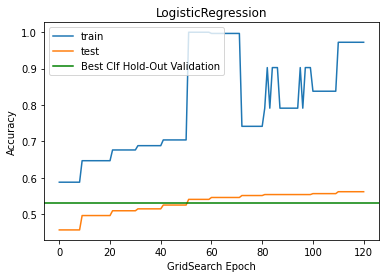

"Best" classifier parameters:
LogisticRegression(C=1, class_weight='balanced', intercept_scaling=3,
                   l1_ratio=0.75)
None



SupportVector

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 670 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 1236 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done 1966 tasks      | elapsed:   20.9s
[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed:   26.3s finished


Best Classifier CV Results:

Train Acc: 0.9009188955996548+/-0.014423868448705565
Test Acc: 0.5644224196855776+/-0.042159821201211305
Hold-Out Validation Acc: 0.5





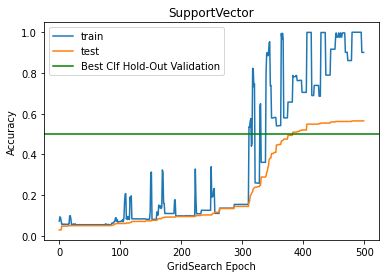

"Best" classifier parameters:
SVC(C=1, class_weight='balanced', degree=4, gamma='auto', probability=True)
None



RandomForest

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 670 tasks      | elapsed:   17.5s
[Parallel(n_jobs=-1)]: Done 1136 tasks      | elapsed:   32.5s
[Parallel(n_jobs=-1)]: Done 1736 tasks      | elapsed:   50.5s


Best Classifier CV Results:

Train Acc: 0.9225668679896464+/-0.013880619595595571
Test Acc: 0.58796992481203+/-0.01661807225962433
Hold-Out Validation Acc: 0.5104166666666666





[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed:  1.1min finished


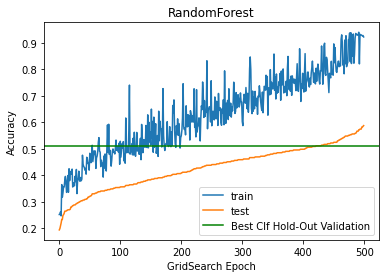

"Best" classifier parameters:
RandomForestClassifier(class_weight='balanced', max_depth=10,
                       max_features='sqrt', min_samples_leaf=5,
                       min_samples_split=5, n_estimators=50)
None







META ITERATION 1





LogisticRegression

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1934 tasks      | elapsed:    2.2s


Best Classifier CV Results:

Train Acc: 0.9672001725625539+/-0.007453868430334791
Test Acc: 0.5539302802460697+/-0.04413166014619782
Hold-Out Validation Acc: 0.5729166666666666





[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed:    2.7s finished
/opt/anaconda3/envs/EM_MC_paper_figs_py36_10/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))
/opt/anaconda3/envs/EM_MC_paper_figs_py36_10/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


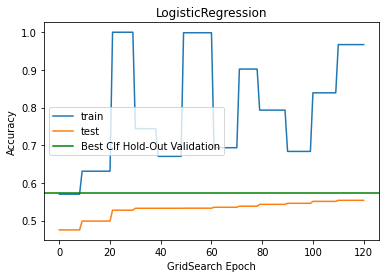

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.


"Best" classifier parameters:
LogisticRegression(C=1, class_weight='balanced', intercept_scaling=3,
                   l1_ratio=0.75)
None



SupportVector

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 670 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 1236 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done 1966 tasks      | elapsed:   19.3s


Best Classifier CV Results:

Train Acc: 1.0+/-0.0
Test Acc: 0.6010594668489405+/-0.012954414604582711
Hold-Out Validation Acc: 0.5729166666666666





[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed:   24.4s finished


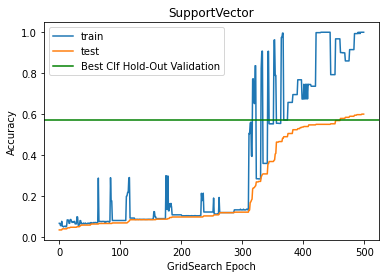

"Best" classifier parameters:
SVC(C=10, class_weight='balanced', degree=5, probability=True)
None



RandomForest

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 248 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 535 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done 984 tasks      | elapsed:   26.2s
[Parallel(n_jobs=-1)]: Done 1626 tasks      | elapsed:   41.5s
[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed:  1.0min finished


Best Classifier CV Results:

Train Acc: 0.9383196721311474+/-0.006691758298978974
Test Acc: 0.6142515379357485+/-0.021360519478402222
Hold-Out Validation Acc: 0.625





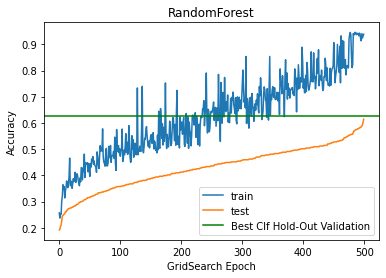

"Best" classifier parameters:
RandomForestClassifier(class_weight='balanced', max_depth=50,
                       max_features='sqrt', min_samples_leaf=5,
                       min_samples_split=5, n_estimators=150)
None







META ITERATION 2





LogisticRegression

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1682 tasks      | elapsed:    1.8s


Best Classifier CV Results:

Train Acc: 0.9028839516824849+/-0.004971046558774747
Test Acc: 0.5642515379357484+/-0.03527472852324505
Hold-Out Validation Acc: 0.6041666666666666





[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed:    2.6s finished
/opt/anaconda3/envs/EM_MC_paper_figs_py36_10/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))


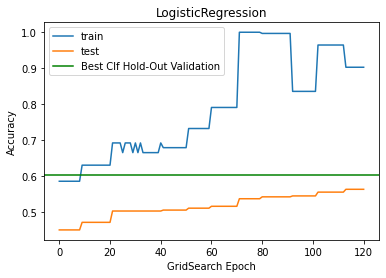

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.


"Best" classifier parameters:
LogisticRegression(C=0.25, class_weight='balanced', intercept_scaling=1.5,
                   l1_ratio=0.75)
None



SupportVector

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 670 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 1236 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done 1966 tasks      | elapsed:   19.8s
[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed:   25.2s finished


Best Classifier CV Results:

Train Acc: 0.9927847282139777+/-0.0038213572360257905
Test Acc: 0.572112098427888+/-0.022498060414379698
Hold-Out Validation Acc: 0.6145833333333334





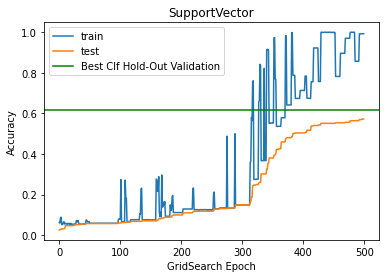

"Best" classifier parameters:
SVC(C=5, class_weight='balanced', gamma='auto', probability=True)
None



RandomForest

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 670 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done 1068 tasks      | elapsed:   27.3s
[Parallel(n_jobs=-1)]: Done 1656 tasks      | elapsed:   44.0s
[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed:  1.1min finished


Best Classifier CV Results:

Train Acc: 0.9363459879206213+/-0.008239952296348415
Test Acc: 0.5853383458646617+/-0.031218856378987497
Hold-Out Validation Acc: 0.59375





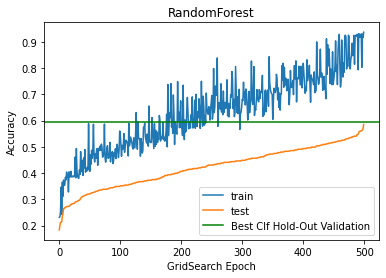

"Best" classifier parameters:
RandomForestClassifier(class_weight='balanced', max_depth=35,
                       max_features='sqrt', min_samples_leaf=5,
                       min_samples_split=10, n_estimators=250)
None





<Figure size 432x288 with 0 Axes>

In [14]:
meta_gs_records = {}
for iii in range(3):
    print(f"\n\n\n\nMETA ITERATION {iii}\n\n\n\n\n")

    
    
    # pop this in so test set is different in the three outer iterations
    label_column = 'MET-type Label'
    X_df = merged_features.copy()

    label_count_dict = X_df[label_column].value_counts().to_dict()
    below_cutoff = [k for k,v in label_count_dict.items() if int(v) < 5]

    X_df = X_df[~X_df[label_column].isin(below_cutoff)]
    X_df = X_df[~X_df[label_column].isnull()]

    
    # Feature selection 
#     clf = RandomForestClassifier(n_estimators=100)
#     clf.fit(X_df[all_feature_columns], X_df[label_column])

#     feature_importances = clf.feature_importances_
#     feature_importance_series = pd.Series(feature_importances, index=all_feature_columns).sort_values(ascending=False)

#     selected_features_importance = feature_importance_series.index.tolist()[:-10]  
#     dropped_features = feature_importance_series.index.tolist()[-10:]
#     feature_cols = selected_features_importance
#     X_df = X_df[[c for c in X_df.columns if c not in dropped_features]]

    feat_means = X_df[all_feature_columns].mean()
    feat_std = X_df[all_feature_columns].std()
    # feature_cols = feature_columns
    X_df[all_feature_columns] = (X_df[all_feature_columns]-X_df[all_feature_columns].mean())/X_df[all_feature_columns].std()


    X = X_df[all_feature_columns].values
    y = X_df[label_column].values
    X_train, X_test, y_train, y_test = train_test_split(X_df[['cell_specimen_id']+all_feature_columns], 
                                                        y,
                                                        stratify=y, 
                                                        test_size=0.2,
#                                                         random_state=42,
                                                       shuffle=True)

    training_ids = X_train['cell_specimen_id'].values
    testing_ids = X_test['cell_specimen_id'].values

    X_train = X_train[all_feature_columns].values
    X_test = X_test[all_feature_columns].values

    assert len(np.unique(y_train)) == len(np.unique(y_test))

    # pop this in so test set is different in the three outer iterations   
    
    
    
    gs_records = {}
    for name, config_dict in meta_config_dict.items():   
        print(name)
        print()
        grid_params = config_dict['parameter_grid']
        this_estimator = config_dict['sklearn_classifier']
        this_gs = RandomizedSearchCV(estimator = this_estimator, 
                           param_distributions = grid_params, 
                           n_iter = 500, 
                           cv = 5, 
                           verbose=2,
                           random_state=42, 
                          return_train_score=True,
                           n_jobs = -1)

        this_gs.fit(X_train,y_train)

        gs_records[name]=this_gs


        best_idx = this_gs.best_index_

        best_test_score_mean = this_gs.cv_results_['mean_test_score'][best_idx]
        best_test_score_std = this_gs.cv_results_['std_test_score'][best_idx]

        best_train_score_mean = this_gs.cv_results_['mean_train_score'][best_idx]
        best_train_score_std = this_gs.cv_results_['std_train_score'][best_idx]

        best_clf_validation_acc = this_gs.best_estimator_.score(X_test, y_test)

        print("Best Classifier CV Results:\n")
        print("Train Acc: {}+/-{}".format(best_train_score_mean,best_train_score_std))
        print("Test Acc: {}+/-{}".format(best_test_score_mean,best_test_score_std))
        print("Hold-Out Validation Acc: {}".format(best_clf_validation_acc))
        print('\n\n')

        gs_df = pd.DataFrame(this_gs.cv_results_)

        gs_df = gs_df[~gs_df['mean_test_score'].isnull()]
        gs_df = gs_df.sort_values(by='mean_test_score')
        plt.plot(range(len(gs_df)), gs_df['mean_train_score'],label='train')
        plt.plot(range(len(gs_df)),gs_df['mean_test_score'],label='test')
        plt.axhline(best_clf_validation_acc,c='green',label='Best Clf Hold-Out Validation')
        plt.title(name)
        plt.ylabel("Accuracy")
        plt.legend()
        plt.xlabel("GridSearch Epoch")
        plt.show()
        plt.clf()
        print('"Best" classifier parameters:')
        print(print(this_gs.best_estimator_))
        print("\n\n")
        
    meta_gs_records[iii] = gs_records

In [15]:
meta_records = {
    
    "Logistic-Regression":{
        "Train Acc":[0.9002545297670406,  0.9645599654874892, 0.9678429680759274],
        "Cross-Validation Acc": [0.5932672590567327, 0.5823308270676691, 0.5719753930280247],
        "Hold-Out Acc":[0.625, 0.57291666666666, 0.5833333333333334]
    },
    
     "Support-Vector":{
        "Train Acc":[0.9206039689387403, 0.8969715271786022, 0.9934404659188957 ],
        "Cross-Validation Acc": [0.5773752563226248, 0.5667805878332193,  0.5904306220095694],
        "Hold-Out Acc":[0.6458333333333334, 0.5729166666666666, 0.6041666666666666]
    },
    
     "RandomForest":{
        "Train Acc":[0.9271678170836928, 0.9337338222605694, 0.9442234685073337, ],
        "Cross-Validation Acc": [0.6010936431989065, 0.5930622009569377, 0.5773752563226248],
        "Hold-Out Acc":[0.5625, 0.6041666666666666, 0.59375]
    }
}


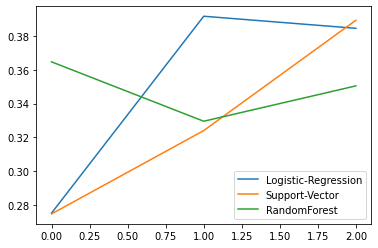

In [17]:
fig,axe=plt.gcf(),plt.gca()
for method, method_dict in meta_records.items():
    variance = np.array(method_dict['Train Acc'])-np.array(method_dict['Hold-Out Acc'])
    axe.plot(variance,label=method)
axe.legend()    

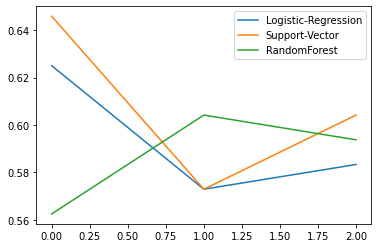

In [18]:
fig,axe=plt.gcf(), plt.gca()
for method, method_dict in meta_records.items():
    
#     variance = np.array(method_dict['Train Acc'])-np.array(method_dict['Hold-Out Acc'])
#     axe.plot(variance,label=method)
    axe.plot(method_dict['Hold-Out Acc'],label=method)
axe.legend()    

In [19]:
# CHOOSING THE RFC THAT HAD THE HIGHEST TEST ACC

chosen_random_forest_gs = meta_gs_records[1]['RandomForest']

best_parameters = chosen_random_forest_gs.best_params_
print(best_parameters)

{'n_estimators': 150, 'min_samples_split': 5, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'max_depth': 50, 'class_weight': 'balanced', 'bootstrap': True}


In [20]:
best_parameters ={'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': 10,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 5,
 'min_samples_split': 10,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 250,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [21]:
chosen_random_forest_gs.best_estimator_.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': 50,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 5,
 'min_samples_split': 5,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 150,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

# Now that we have identified optimal model params for the pseq classifier,we will generate a confusion Matrix for Chosen RFC

In [22]:
best_classifier = RandomForestClassifier(**best_parameters)

pseq_data_df = merged_features.copy()
keep_mets = [k for k,v in pseq_data_df['MET-type Label'].value_counts().to_dict().items() if v>=5]
pseq_data_df = pseq_data_df[pseq_data_df['MET-type Label'].isin(keep_mets)]

In [23]:
training_samples_by_met_type = pseq_data_df['MET-type Label'].value_counts().to_dict()

In [33]:
from sklearn.metrics import confusion_matrix
from copy import copy
def clf_stratified(df, ft_cols,labels_col,title, clf_obj, undersample_dict = {}, num_folds=5,num_outter_its=1):
    """
    Will run  labels_col prediction  with stratified kfold to properly include all ttypes in each train/test split
    
    num folds should  equal 5 if we are doing an n>=5 threshold
    undersample_dict = dicitonary where keys are met-labels and values are the fraction of datapoints to drop
    from that group
    clf_obj should be an unfit classifier object
    
    """
    df = copy(df)
#     shape_0=len(df)
#     df.dropna(inplace=True)
#     shape_1=len(df)
    
#     if shape_1 != shape_0:
#         print("Dropped {} Nan Containing Cells".format(shape_0-shape_1))
        
    n_ct_series = df.groupby(labels_col)[labels_col].transform('size').astype(str)
    n_ct_series = ' (n=' + n_ct_series + ')'
#     df[labels_col] = df[labels_col] + n_ct_series.astype(str)
    

    feature_values = df[ft_cols].values
    labels = df[labels_col].values

    min_num_groupsize = min(df[labels_col].value_counts().to_dict().values())
    if min_num_groupsize < 5:
        num_folds = min_num_groupsize
        
    if num_folds < 2:
        num_folds = 2
    print('-----------------------------------------------------------------')
    print('RFC by {}'.format(labels_col))
    print('-----------------------------------------------------------------'+'\n')

    print('There are {} unique labels in the {} cells'.format(len(df[labels_col].unique()),len(labels)))
    print('')
    print(df[labels_col].value_counts())
    print('')

    score = np.zeros(len(ft_cols))
    avg_score = []

    possible_labels = df[labels_col].unique()
    num_correct = dict(zip(possible_labels,np.zeros(len(possible_labels))))
    num_occurances = dict(zip(possible_labels,np.zeros(len(possible_labels))))
    value_counts_dict = dict(zip(df[labels_col].unique(),df[labels_col].value_counts()))
    conf_mat = np.zeros([len(np.unique(labels)),len(np.unique(labels))])

    for it in range(num_outter_its):# range(0,100//num_folds):
        
        #shuffle data, train and test
        skfold = StratifiedKFold(n_splits=num_folds, random_state=None, shuffle=True)

        feature_values = df[ft_cols].values
        labels = df[labels_col].values
        
        if undersample_dict != {}:
            
            train_df = pd.DataFrame(np.hstack((feature_values, labels.reshape(-1,1))),columns=ft_cols+[labels_col])
            for k,pct_to_erod in undersample_dict.items():
                n_drop_from_training = int( len(train_df[train_df['met_type']==k])*pct_to_erod)
                tr_drop_index = np.random.choice(train_df[train_df['met_type']==k].index, n_drop_from_training, replace=False, )
                train_df = train_df.loc[~train_df.index.isin(tr_drop_index)]

            feature_values = train_df[feature_columns].values
            labels = train_df['met_type'].values
            
            print(train_df['met_type'].value_counts())
        
        for train_index, test_index in skfold.split(feature_values, labels):
            X_train = feature_values[train_index]
            Y_train = labels[train_index]

            X_test = feature_values[test_index]
            Y_test = labels[test_index]
            
            
            clf = clone(clf_obj)

                
            clf.fit(X_train, Y_train)

            results = clf.predict(X_test)

            # getting per class accuracy scores
            for ind,res in enumerate(results):
                num_occurances[Y_test[ind]]+=1
                if res == Y_test[ind]:
                    num_correct[res]+=1           

            conf_mat+=confusion_matrix(Y_test,results,labels = possible_labels)

            mean_score = clf.score(X_test,Y_test)
            avg_score.append(mean_score)
#             score+=clf.feature_importances_


    Average_performance = np.mean(np.asarray(avg_score))
    Std_performance = np.std(np.asarray(avg_score))
    score_dict = dict(zip(score,ft_cols))
    sorted_scores_dict = {}
    for enum,i in enumerate(sorted(score_dict,reverse=True)):
        sorted_scores_dict[i] = score_dict[i]
        print(score_dict[i])
    
    for ke in value_counts_dict.keys():
        class_acc = num_correct[ke]/num_occurances[ke]

    fig = plt.gcf()
    ax = plt.gca()
    row_sums = np.sum(conf_mat,axis=1)
    raw_confusion_df = pd.DataFrame(conf_mat,columns=possible_labels,index=possible_labels)
    percent_conf_mat = (conf_mat.T / row_sums).T
    np.nan_to_num(percent_conf_mat,0)

    
    
    use_custom_sort = False
    
    if use_custom_sort:
        subclass_order = ["IT","PT","NP","CT","L6b"]
        sorted_labels = sorted(possible_labels, key=lambda x: (subclass_order.index(x.split("-")[0]),x.split("-")[-1]))
    else:
        sorted_labels = sorted(possible_labels)
    
    confusion_df = pd.DataFrame(percent_conf_mat,columns=possible_labels)
    confusion_df.set_index([possible_labels],inplace=True)
    confusion_df = confusion_df[sorted_labels]
    
    if use_custom_sort:
        new_confusion_df = pd.DataFrame()
        for lab in sorted_labels:
            this_lab = confusion_df.loc[lab]
            new_confusion_df= new_confusion_df.append(this_lab)
        confusion_df = new_confusion_df[sorted_labels]
        
    else:
        confusion_df.sort_index(inplace=True) 

    vals = confusion_df.values
    vals = vals.astype(object)
    for i in range(len(vals)):
        for j in range(len(vals)):
            if i==j:
                vals[i,j] = str(round(vals[i,j],2))
                continue
            else:
                vals[i,j] = ''
    diagonal_vals = vals.astype('str')

    con = sns.heatmap(confusion_df,
                      annot=diagonal_vals,
                      fmt = '', 
                      xticklabels=sorted_labels,
                      yticklabels= sorted_labels,
                     vmin=0,vmax=1.0,
                      annot_kws={"size":8})

    ax.set_xticklabels(ax.get_xticklabels(), rotation=90,horizontalalignment='right')
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0,horizontalalignment='right')

    con.set_xlabel('Prediction')
    con.set_ylabel('Truth')

    fig.set_size_inches(8,7)
    confusion_title = title + ' acc = {} +/- {}'.format(round(Average_performance,3),round(Std_performance,3))
    ax.set_title(confusion_title)
    return fig,ax, sorted_scores_dict, confusion_df, raw_confusion_df


In [35]:
from tqdm import tqdm
from sklearn.base import clone


def predict_labels_with_probability(source_dataframe,
                                    prediction_dataframe,
                                    prediction_id_column,
                                    feature_columns,
                                    label_column,
                                    clf_obj,
                                    min_class_size = 5,
                                    min_class_size_subsampling=5,
                                    feature_weights=None,
                                    num_iterations=500,
                                    subsampling_rate=0.95,
                                    undersample_dict={},
                                   ):
    
    """

    :param source_dataframe: dataframe, the training dataframe (IVSCC) must have all feature columns and label_column (e.g. met_type)
    :param prediction_dataframe: dataframe, the dataframe you would like to assign labels to, must have all feature columns and an id column
    :param prediction_id_column: str, specimen id column in the prediction dataframe
    :param feature_columns: list of features, must be present in both dataframes
    :param label_column: str, what column from the source_dataframe  you want to predict 
    :param min_class_size: int, the smallest representation allowed in training data, instances from a class with fewer than this value will be dropped
    :param min_class_size_subsampling: int, when subsampling, what is the smallest you want to erode any given class of training data
    :param feature_weights: list/array of feature weights if you want to scale them for any distance based metrics
    :param num_iterations: int, how many iterations of classification to run
    :param subsampling_rate: float in range 0-1.0. Represents the percent of IVSCC cells to subsample in each iteration


    :return: result_df: dataframe, has the following columns: ["id",'predicted_label_column','probability']
    :return: results: mxn numpy array, m = prediction cells, n=all unique possible labels, the ith,jth value indicates how 
    many times the ith cell was predited to be the jth label
    :return: all_accuracies: list, keeps track of either oob_score or training error of each classifier
    """
    prediction_dataframe=prediction_dataframe.copy(deep=True)
#     prediction_dataframe.fillna(0,inplace=True)
    
    source_dataframe=source_dataframe.copy()
    
    labels_above_threshold = [k for k,v in source_dataframe[label_column].value_counts().to_dict().items() if v>=min_class_size]
    source_dataframe = source_dataframe[source_dataframe[label_column].isin(labels_above_threshold)]
    
    num_source_datapoints_to_drop = int(len(source_dataframe)*(1-subsampling_rate))

#     if not feature_weights:
#         feature_weights = [1]*len(feature_columns)
        
    prediction_data_array = prediction_dataframe[feature_columns].values
#     prediction_data_array = np.multiply(prediction_data_array,feature_weights)
    prediction_ids = prediction_dataframe[prediction_id_column].tolist()
    
    unique_labels = source_dataframe[label_column].unique().tolist()
    results = np.zeros((len(prediction_ids), len(unique_labels)))
    

    all_accuracies = []
    for outter_it in tqdm(range(num_iterations)):
        
        if undersample_dict == {}:

            #subsample the entirety of our source dataset according to subsampling_rate
            source_labels_value_counts = source_dataframe[label_column].value_counts().to_dict()
            source_dataframe_subsampled = source_dataframe.copy(deep=True)
            for _ in range(num_source_datapoints_to_drop):

                available_labels_to_drop = [k for k,v in source_labels_value_counts.items() if v>min_class_size_subsampling]
                current_number_of_cells = sum([source_labels_value_counts[v] for v in available_labels_to_drop])
                probability_of_available_labels = [source_labels_value_counts[k]/current_number_of_cells for k in available_labels_to_drop]
                if available_labels_to_drop:
                    label_to_drop = np.random.choice(available_labels_to_drop,p=probability_of_available_labels)
                    idx_to_drop = np.random.choice(source_dataframe_subsampled[source_dataframe_subsampled[label_column]==label_to_drop].index)
                    source_dataframe_subsampled = source_dataframe_subsampled.drop(idx_to_drop)
                    source_labels_value_counts[label_to_drop] = source_labels_value_counts[label_to_drop] - 1 

        else:
            source_dataframe_subsampled = source_dataframe.copy(deep=True)            
            for k,pct_to_erod in undersample_dict.items():
                n_drop_from_training = int( len(source_dataframe_subsampled[source_dataframe_subsampled['met_type']==k])*pct_to_erod)
                tr_drop_index = np.random.choice(source_dataframe_subsampled[source_dataframe_subsampled['met_type']==k].index, n_drop_from_training, replace=False, )
                source_dataframe_subsampled = source_dataframe_subsampled.loc[~source_dataframe_subsampled.index.isin(tr_drop_index)]

           
            
#             print(source_dataframe_subsampled[label_column].value_counts())
        
        feature_values = source_dataframe_subsampled[feature_columns].values
#         feature_values = np.multiply(feature_values,feature_weights)
        labels = source_dataframe_subsampled[label_column].values
        
        classifier = clone(clf_obj)
    
        classifier.fit(feature_values, labels)
        
        if hasattr(classifier, 'oob_score_'):
            all_accuracies.append(classifier.oob_score_)
            
        else:
            all_accuracies.append(classifier.score(feature_values, labels))

        predictions = classifier.predict(prediction_data_array)
        predictions_by_id = dict(zip(prediction_ids,predictions))
        # keep track of predictions 
        for sample_id, pred_label in predictions_by_id.items():
            row_idx = prediction_ids.index(sample_id)
            col_ids = unique_labels.index(pred_label)
            results[row_idx, col_ids]+=1
        
       
    # create simple dataframe     
    chosen_label_indices = np.argmax(results,axis=1)
    chosen_label_occurence = np.max(results,axis=1)
    chosen_labels = [unique_labels[i] for i in chosen_label_indices]
    probability = chosen_label_occurence/num_iterations

    result_df = pd.DataFrame({"id":prediction_ids,
                 f"predicted_{label_column}":chosen_labels,
                 "probability":probability})

    return result_df, results, all_accuracies


In [ ]:
pseq_rfc_fig, pseq_rfc_axe, pseq_scores, pseq_cmat, pseq_raw_cmat =  clf_stratified(df=pseq_data_df,
                                                                                   ft_cols=all_feature_columns,
                                                                                   labels_col='MET-type Label',
                                                                                   title='Patch-seq MET-Type Predictions', 
                                                                                   clf_obj=best_classifier, 
                                                                                   undersample_dict = {}, 
                                                                                   num_folds=5,
                                                                                   num_outter_its=20)


-----------------------------------------------------------------
RFC by MET-type Label
-----------------------------------------------------------------

There are 22 unique labels in the 477 cells

Sst-MET-12     55
Lamp5-MET-1    43
Pvalb-MET-4    41
Pvalb-MET-2    32
Sncg-MET-1     32
Sst-MET-3      26
Sst-MET-13     23
Vip-MET-1      23
Vip-MET-5      21
Sst-MET-6      18
Sst-MET-2      18
Sst-MET-8      18
Vip-MET-4      17
Sst-MET-1      16
Sst-MET-4      15
Vip-MET-2      15
Sst-MET-9      14
Sst-MET-5      12
Sst-MET-7      11
Pvalb-MET-3    10
Sst-MET-10     10
Pvalb-MET-1     7
Name: MET-type Label, dtype: int64



In [25]:
pseq_rfc_fig.savefig("Final_Patch_Seq_RFC_Conf_Matrix.png",dpi=400,bbox_inches='tight')

NameError: name 'pseq_rfc_fig' is not defined

In [26]:
pseq_raw_cmat.to_csv("Final_Patch_Seq_RFC_Conf_Matrix.csv")

NameError: name 'pseq_raw_cmat' is not defined

In [27]:
pseq_cmat.to_csv("Final_Patch_Seq_RFC_Conf_Matrix_RowNorm.csv")

NameError: name 'pseq_cmat' is not defined

# Use the above classifier to predict labels for EM data

In [28]:
em_feature_df = pd.read_csv("./NotebookInputs/inh_em_RawFeatureWide.csv")
best_classifier = RandomForestClassifier(**best_parameters)


In [29]:
em_met_result_df, em_results, em_all_accuracies = predict_labels_with_probability(source_dataframe=pseq_data_df,
                                                                                prediction_dataframe=em_feature_df,
                                                                                prediction_id_column='specimen_id',
                                                                                feature_columns=all_feature_columns,
                                                                                label_column="MET-type Label",
                                                                                clf_obj = best_classifier,
                                                                                min_class_size = 5,
                                                                                min_class_size_subsampling=5,
                                                                                feature_weights=None,
                                                                                num_iterations=500,
                                                                                subsampling_rate=0.95,
                                                                                undersample_dict={},
                                                                               )

NameError: name 'predict_labels_with_probability' is not defined

In [30]:
em_met_result_df.to_csv("Final_EM_MetType_Preds_RFC_Resamp_AllFeats_NoRadius.csv")

NameError: name 'em_met_result_df' is not defined

In [31]:
em_met_result_df.probability.describe()

NameError: name 'em_met_result_df' is not defined

In [32]:
em_met_result_df["num_pseq_training_samples"] = em_met_result_df['predicted_MET-type Label'].map(training_samples_by_met_type)

NameError: name 'em_met_result_df' is not defined

In [ ]:
previous_predictions = pd.read_csv("../big_batch_v1_correct_layer_template/EM_MC_Predicted_MET_Labels_11_18_22.csv")
previous_predictions.columns=[c+"_previous" for c in previous_predictions.columns]

compare_df = previous_predictions.merge(em_met_result_df,left_on='id_previous',right_on='id')
compare_df[compare_df['predicted_MET-type Label_previous']!=compare_df['predicted_MET-type Label']]

,Unnamed: 0_previous,id_previous,predicted_MET-type Label_previous,probability_previous,id,predicted_MET-type Label,probability
1,2,864691135118298333,Sst-MET-6,0.598,864691135118298333,Sst-MET-4,0.79
